**Experiment Description:**   
- **Purpose:** Measure the effect of Proportion Estimation under different training data size and different inlier proportions in test data
- **Experimental Design:** Range the proportions of type 1 inliers in test data from 0.01 to 1, see the MSE of estimated proprotions of these three methods under training size = [30, 30], [50, 50], [100, 100]
- **Comparing Methods:** Classification, Mixture Model using Normal Fitting and Gamma Fitting
  
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM
  
- **Data Shapes:** Uniform + Normal, with 50 dimensions
- **Size of Calibration Data:** [500, 500]  
- **Size of Test Data:** 1800 inliers and 200 outliers  
- **Measure of Estimation Error:** MSE Error between the estimated proportions and the true proportions in the unlabeled data  
- **Conclusion:**
1. The estimation deviation of using classification to estimate proportions is much higher than that of the mixture model, and the gamma fitting mixture model is better than the normal fitting;
2. A larger size of training data improves the estimation effect of the Mixture Model using the `Pomegranate` package;
3. When the proportion of inliers in the training data is highly different than that in the unlabeled data, the estimations error is greater

### Setup

In [29]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
import copy
import pomegranate
import torch
from pomegranate.distributions import *
from pomegranate.gmm import GeneralMixtureModel

np.set_printoptions(suppress=True)
%load_ext watermark
%watermark -m -n -p numpy,torch,pomegranate

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores,prepare_pu_score_matrices
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power, train_occ, scale_data
from mypackage.proportion_estimation import estimate_test_proportions, estimate_unlabeled_proportions, compute_proportion_error, compute_scores, fit_mixture_model
from mypackage.plot_figures import train_histograms_with_distributions, unlabeled_histograms_with_distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.26.4
torch      : 2.4.0
pomegranate: 1.1.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



## Data Generation

In [34]:
np.random.seed(0)

# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 3

## Training, Calibration, and Test data
# List of different sizes for training data
sizes_per_train = [30, 50, 100]

n_in_train = [100, 100, 100]
n_in_cal = [500, 500]
num_in_test = 1800
n_in_test = [1782, 18]
n_out_test = 200
n_test = num_in_test + n_out_test

# Range of rho values
rho_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Monte Carlo iterations
num_iterations = 10

## Preparation

In [74]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

# Define machine learning models
binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

In [75]:
# Store results
all_proportion_difference = {size: {'classification': [], 'normal': [], 'gamma': []} for size in sizes_per_train}
all_ci_proportion_difference = {size: {'classification': [], 'normal': [], 'gamma': []} for size in sizes_per_train}

## PU Learning

In [76]:
for size_per_train in sizes_per_train:
    # Training sample
    n_in_train = [size_per_train]* K
    for rho in rho_values:
        # Test samples
        n_in_test = [int(rho * num_in_test)] + [(num_in_test - int(rho * num_in_test)) // (K - 1)] * (K - 1)
        
        # Adjust remaining test samples
        remaining_test_samples = num_in_test - sum(n_in_test)
        for i in range(remaining_test_samples):
            n_in_test[1 + i % (K - 1)] += 1
            
        # Calculate the proportions of each type of inliers in the calibration and test data
        n_in_cal_test = [cal + test for cal, test in zip(n_in_cal, n_in_test)]
        n_in_total = sum(n_in_cal_test)
        proportions = [count / n_in_total for count in n_in_cal_test]
        proportions = torch.tensor(proportions, dtype=torch.float32)

        proportion_difference_classification = []
        proportion_difference_normal = []
        proportion_difference_gamma = []

        for _ in range(num_iterations):
            # Generate initial training, calibration, and test data
            X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
            X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
            X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
            X_unlabeled = np.vstack((X_cal, X_test))

            # Get a list of OCC
            X_train_scaled = scale_data(X_train, X_train)
            occ_list = train_occ(K, X_train_scaled, Y_train, oneclass_classifier)

            # Adjust the proportions in the training data
            proportions_classification = estimate_test_proportions(X_train, Y_train, X_unlabeled, occ_list, K)
            proportions_normal = estimate_unlabeled_proportions(K, X_train, Y_train, X_unlabeled, occ_list, mixture_distributions="normal")
            proportions_gamma = estimate_unlabeled_proportions(K, X_train, Y_train, X_unlabeled, occ_list, mixture_distributions="gamma")

            # Compute Proportion Error
            proportion_difference_classification.append(compute_proportion_error(proportions, proportions_classification, metric='mse'))
            proportion_difference_normal.append(compute_proportion_error(proportions, proportions_normal, metric='mse'))
            proportion_difference_gamma.append(compute_proportion_error(proportions, proportions_gamma, metric='mse'))

        # Calculate mean distances and confidence intervals
        all_proportion_difference[size_per_train]['classification'].append(np.mean(proportion_difference_classification))
        all_proportion_difference[size_per_train]['normal'].append(np.mean(proportion_difference_normal))
        all_proportion_difference[size_per_train]['gamma'].append(np.mean(proportion_difference_gamma))

        # Compute the standard deviation
        all_ci_proportion_difference[size_per_train]['classification'].append((np.percentile(proportion_difference_classification, 5), np.percentile(proportion_difference_classification, 95)))
        all_ci_proportion_difference[size_per_train]['normal'].append((np.percentile(proportion_difference_normal, 5), np.percentile(proportion_difference_normal, 95)))
        all_ci_proportion_difference[size_per_train]['gamma'].append((np.percentile(proportion_difference_gamma, 5), np.percentile(proportion_difference_gamma, 95)))

## Plot

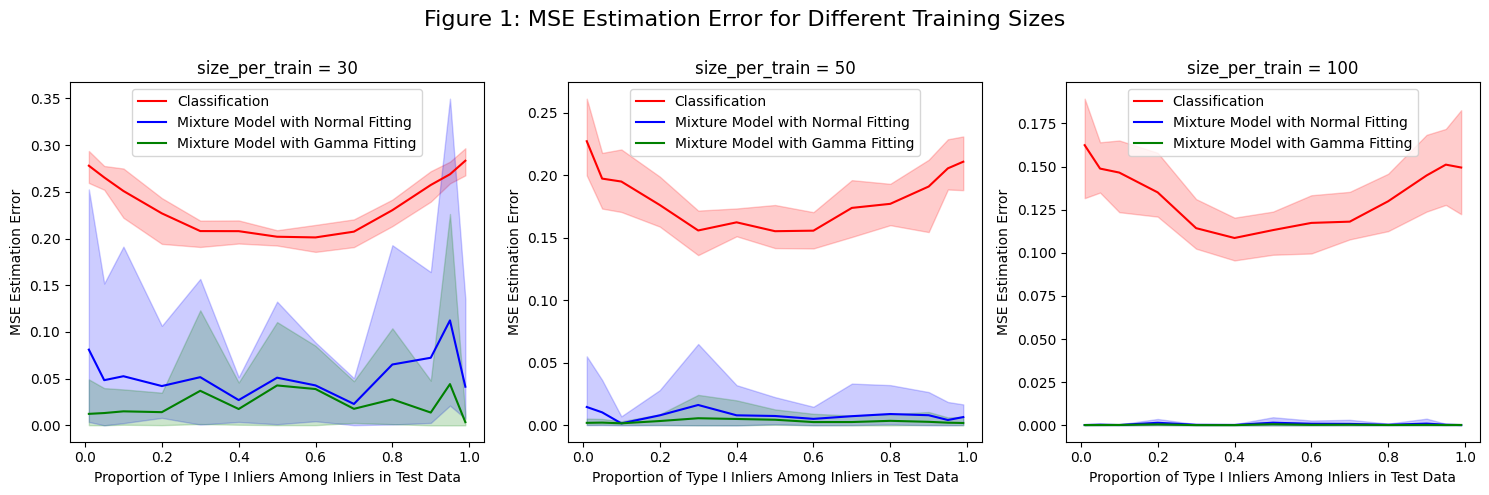

In [77]:
# Plotting
plt.figure(figsize=(15, 5))

for i, size_per_train in enumerate(sizes_per_train):
    plt.subplot(1, 3, i + 1)
    
    plt.plot(rho_values, all_proportion_difference[size_per_train]['classification'], label='Classification', color='r')
    plt.fill_between(rho_values, [ci[0] for ci in all_ci_proportion_difference[size_per_train]['classification']],
                     [ci[1] for ci in all_ci_proportion_difference[size_per_train]['classification']], color='r', alpha=0.2)
    
    plt.plot(rho_values, all_proportion_difference[size_per_train]['normal'], label='Mixture Model with Normal Fitting', color='b')
    plt.fill_between(rho_values, [ci[0] for ci in all_ci_proportion_difference[size_per_train]['normal']],
                     [ci[1] for ci in all_ci_proportion_difference[size_per_train]['normal']], color='b', alpha=0.2)
    
    plt.plot(rho_values, all_proportion_difference[size_per_train]['gamma'], label='Mixture Model with Gamma Fitting', color='g')
    plt.fill_between(rho_values, [ci[0] for ci in all_ci_proportion_difference[size_per_train]['gamma']],
                     [ci[1] for ci in all_ci_proportion_difference[size_per_train]['gamma']], color='g', alpha=0.2)
    
    plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
    plt.ylabel('MSE Estimation Error')
    plt.title(f'size_per_train = {size_per_train}')
    plt.legend()

plt.suptitle('Figure 1: MSE Estimation Error for Different Training Sizes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Experiment Description:**   
- **Purpose:** Measure the effect of Proportion Estimation under different training data size and different inlier proportions in test data
- **Experimental Design:** Range the proportions of type 1 inliers in test data from 0.01 to 1, see the MSE of estimated proprotions of these three methods under training size = [30, 30], [50, 50], [100, 100]
- **Comparing Methods:** Classification, Mixture Model using Normal Fitting and Gamma Fitting
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Data Shapes:** Uniform + Normal, with 50 dimensions  
- **Size of Calibration Data:** [500, 500]  
- **Size of Test Data:** 1800 inliers and 200 outliers  
- **Measure of Estimation Error:** MSE Error between the estimated proportions and the true proportions in the unlabeled data  
- **Conclusion:**
1. The estimation deviation of using classification to estimate proportions is much higher than that of the mixture model, and the gamma fitting mixture model is better than the normal fitting;
2. A larger size of training data improves the estimation effect of the Mixture Model using the `Pomegranate` package;
3. When the proportion of inliers in the training data is highly different than that in the unlabeled data, the estimations error is greater
4. The minimum size of one type of inliers in the training data should be larger than 30, otherwise the EM algorithm in `Pomegranate` couldn't work(data size of this training data is too small to fit a normal/gamma distribution)

In [78]:
n_in_train = [300, 300]
X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
Y_unlabeled = np.concatenate((Y_cal, Y_test))
X_unlabeled = np.vstack((X_cal, X_test))
X_train_scaled = scale_data(X_train, X_train)
X_unlabeled_scaled = scale_data(X_train, X_unlabeled)
occ_list = train_occ(K, X_train_scaled, Y_train, oneclass_classifier)
scores_train, scores_unlabeled = compute_scores(K, occ_list, X_train_scaled, Y_train, X_unlabeled_scaled)
model_final_normal = fit_mixture_model(K, scores_train, scores_unlabeled, 'normal')
model_final_gamma = fit_mixture_model(K, scores_train, scores_unlabeled, 'gamma')

**Image Description of Below Four Figures:**   
- **Purporse:** To show the effect of mixture model fitting using `Pomegranate` package
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Size of Training Data:** [300, 300]
- **Size of Unlabeled Data:** 1782 type I inliers, 18 type II inliers and 200 outliers  
- **Conclusion:** The the Mixture Model using the `Pomegranate` package can fit the scores quiet well.

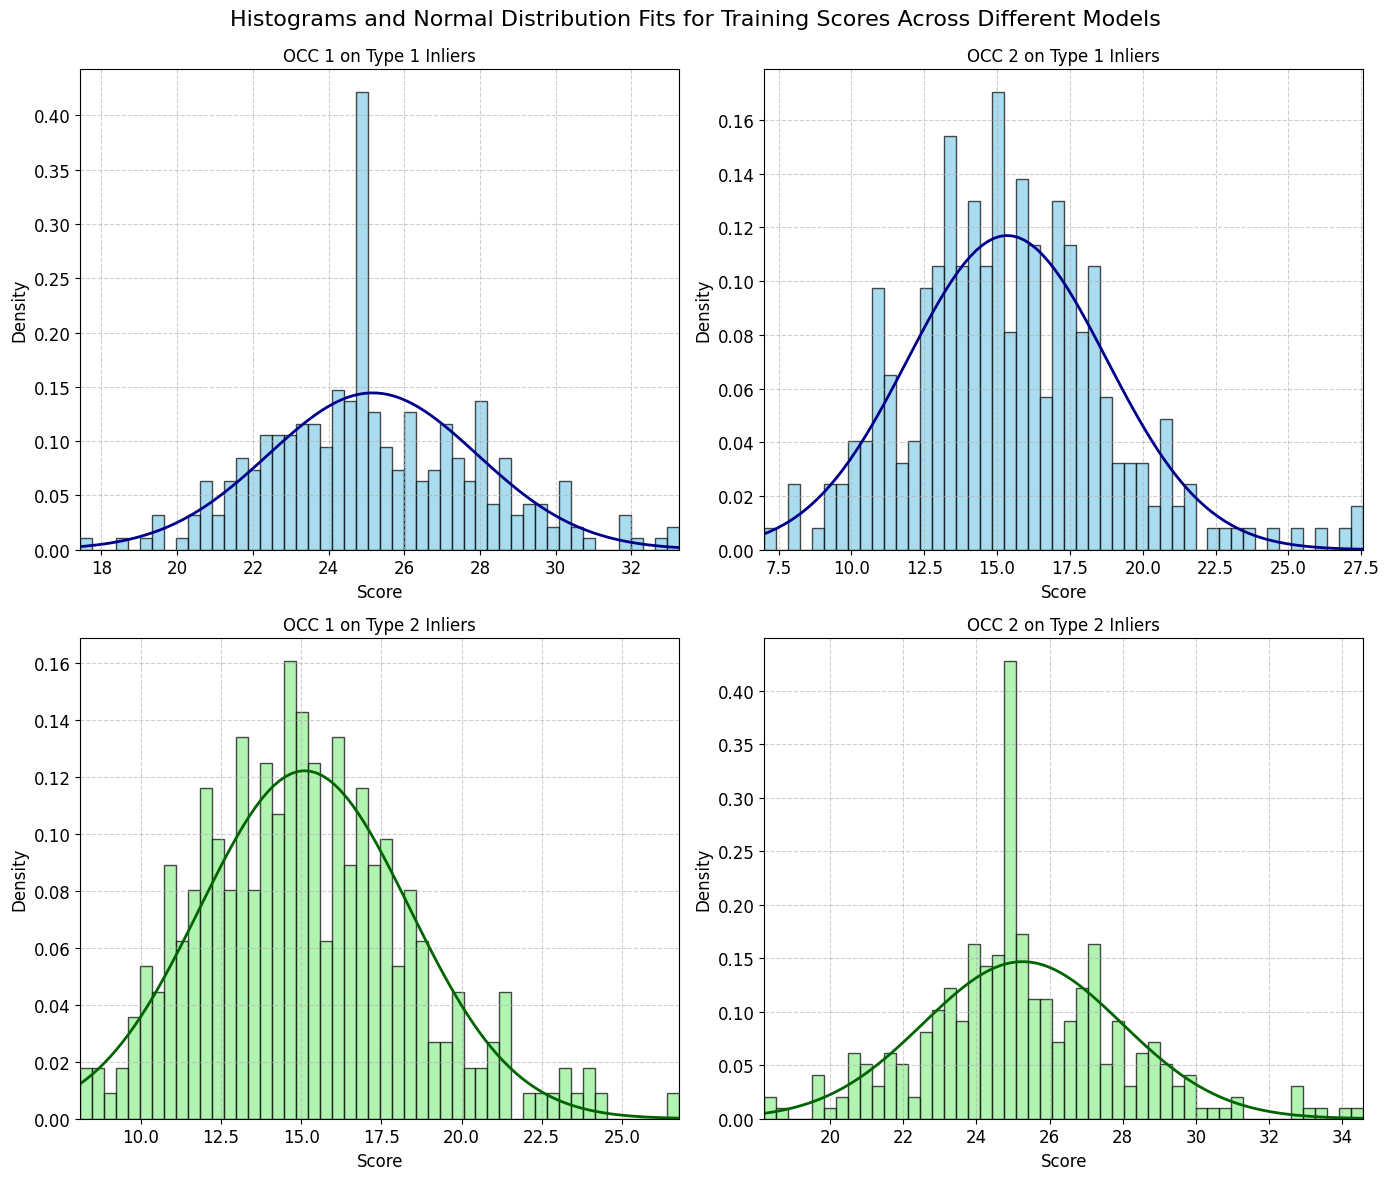

In [79]:
train_histograms_with_distributions(K, scores_train, model_final_normal, mixture_distribution = 'normal')

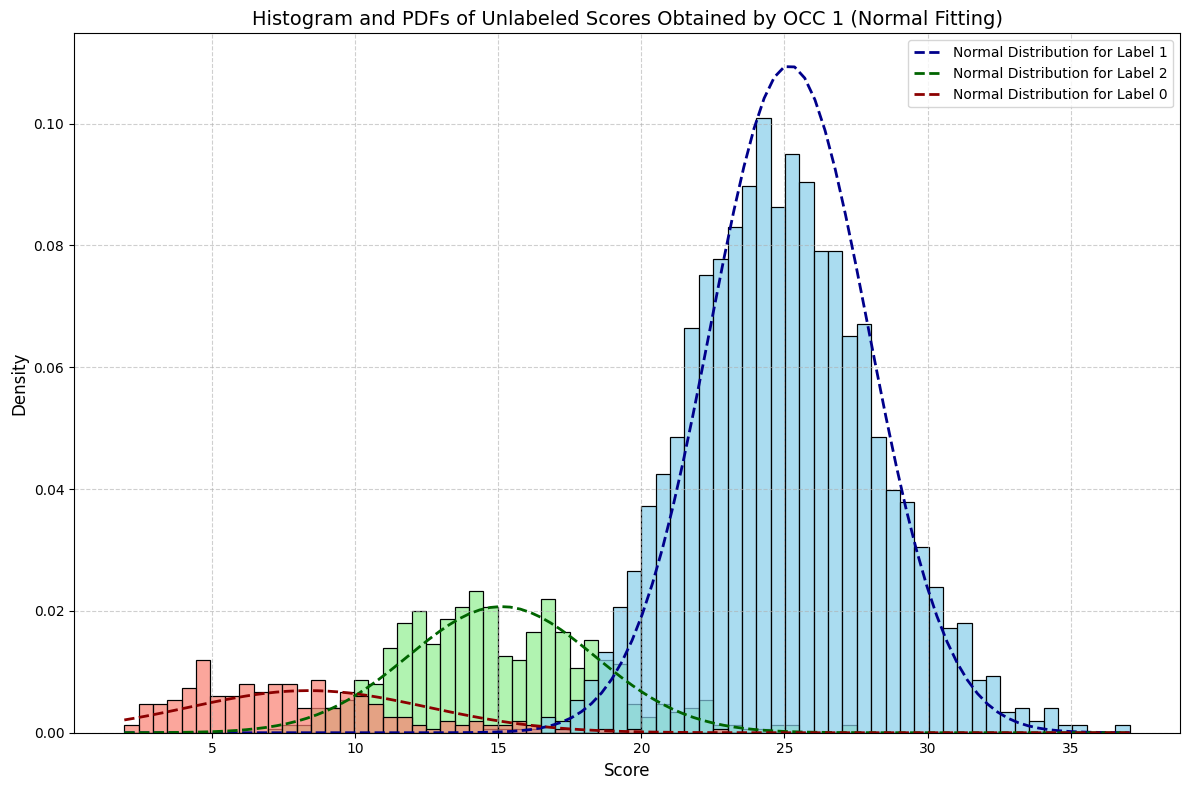

In [80]:
unlabeled_histograms_with_distributions(K, scores_unlabeled, Y_unlabeled, model_final_normal, mixture_distribution='normal')

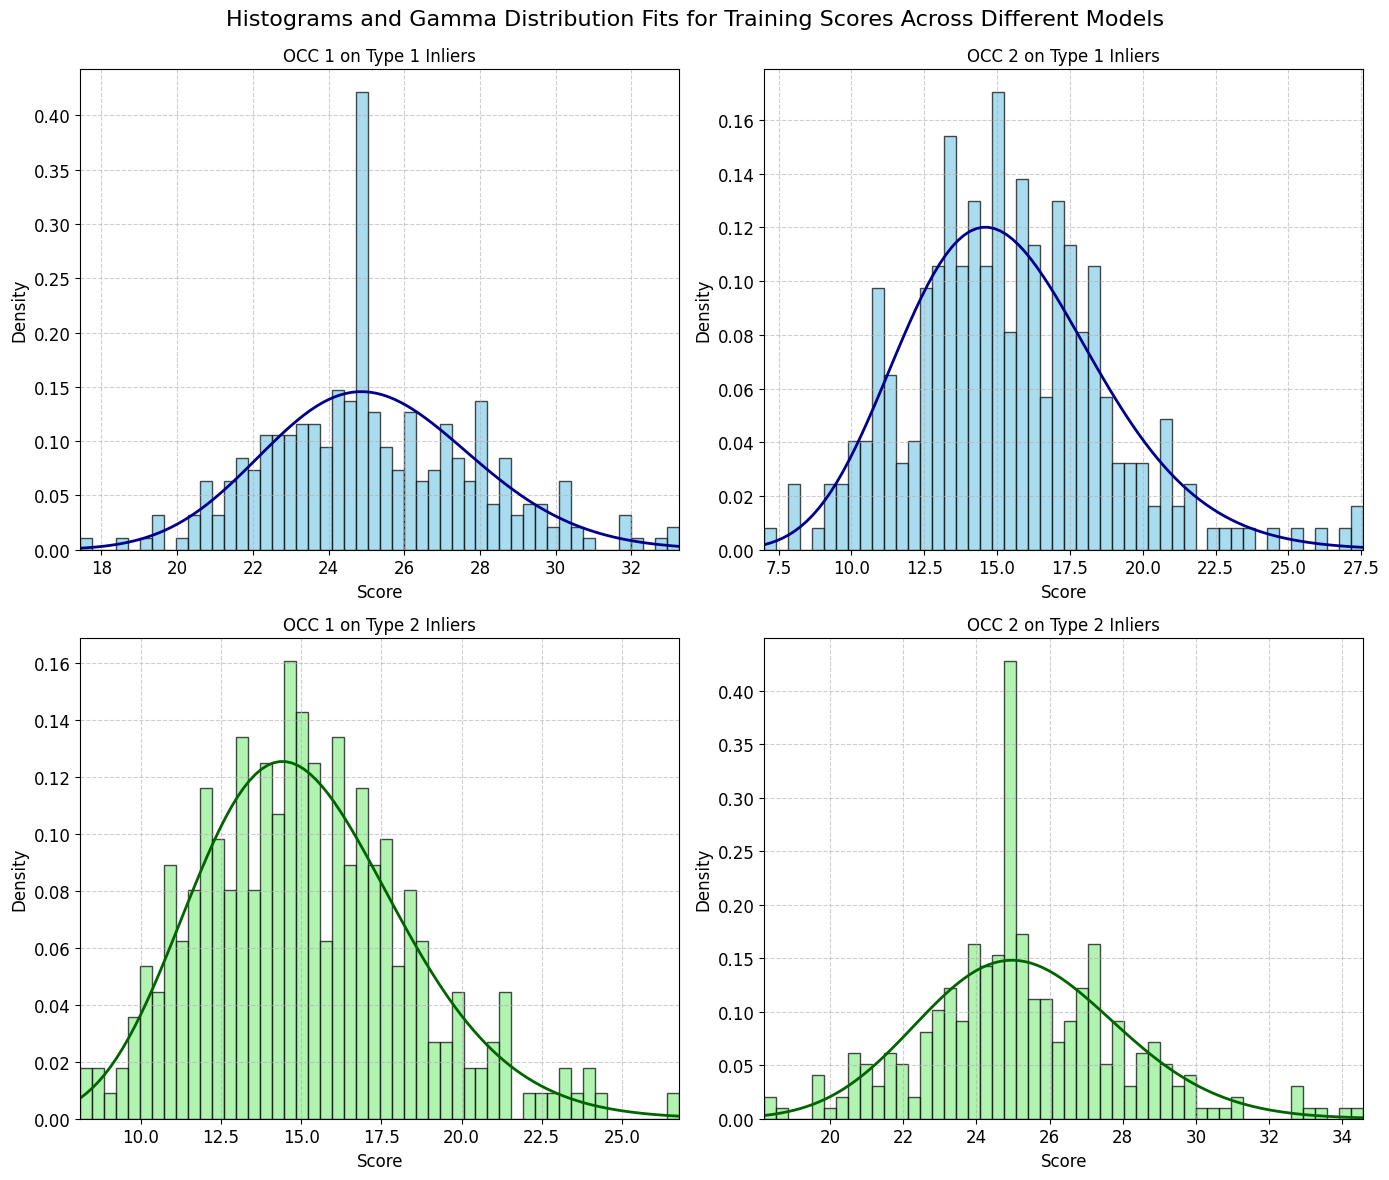

In [81]:
train_histograms_with_distributions(K, scores_train, model_final_gamma, mixture_distribution = 'gamma')

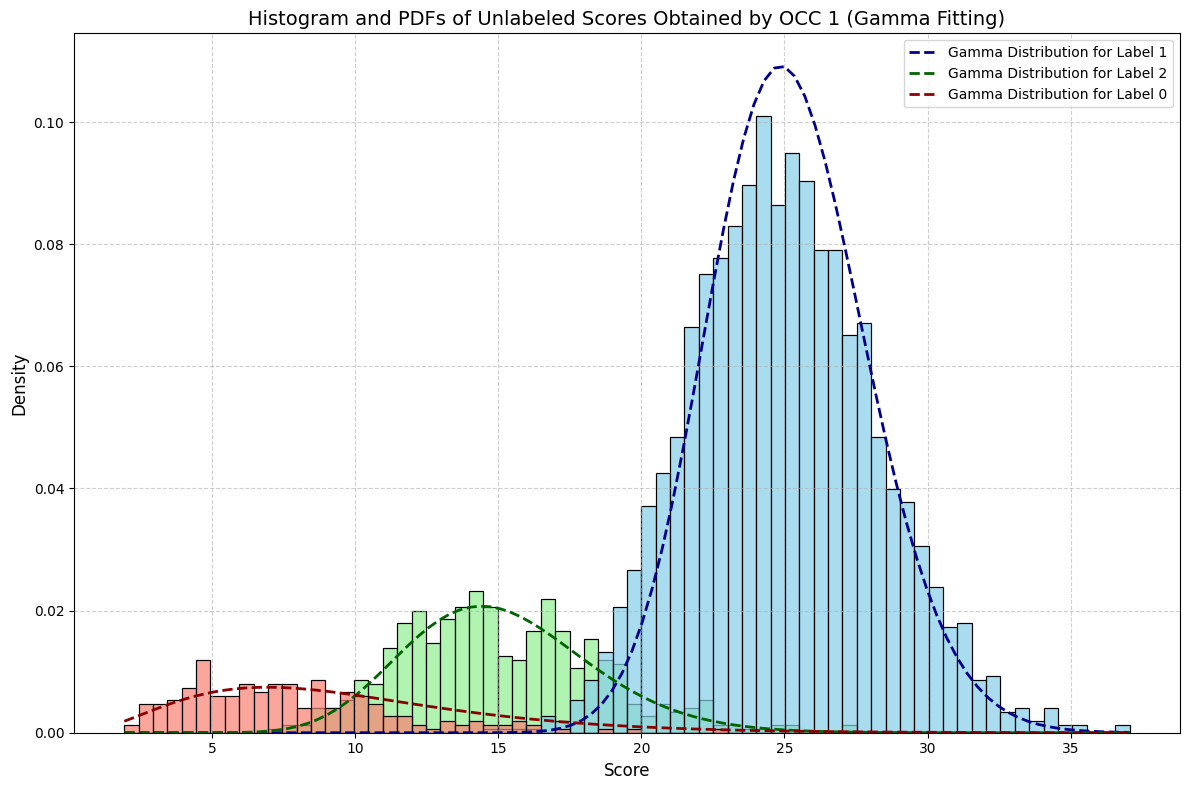

In [82]:
unlabeled_histograms_with_distributions(K, scores_unlabeled, Y_unlabeled, model_final_gamma, mixture_distribution='gamma')